In [17]:
import numpy as np
import pandas as pd 
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score
from keras.utils import to_categorical





directory = 'C:/Users/Divam/OneDrive/Desktop/Confidence'
data = pd.read_csv('C:/Users/Divam/OneDrive/Desktop/Confidence/confident_data/output1.csv')
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory, x))
data





,is_confident,gender,filename
0,confident,male,C:/Users/Divam/OneDrive/Desktop/Confidence\con...
1,confident,male,C:/Users/Divam/OneDrive/Desktop/Confidence\con...
2,confident,male,C:/Users/Divam/OneDrive/Desktop/Confidence\con...
3,confident,male,C:/Users/Divam/OneDrive/Desktop/Confidence\con...
4,confident,male,C:/Users/Divam/OneDrive/Desktop/Confidence\con...
...,...,...,...
99,non confident,male,C:/Users/Divam/OneDrive/Desktop/Confidence\con...
100,non confident,male,C:/Users/Divam/OneDrive/Desktop/Confidence\con...
101,non confident,male,C:/Users/Divam/OneDrive/Desktop/Confidence\con...
102,non confident,male,C:/Users/Divam/OneDrive/Desktop/Confidence\con...


In [18]:
def extract_features(filename, max_length=216):
    y, sr = librosa.load(filename, duration=2.5, offset=0.6)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    if log_mel.shape[1] < max_length:
        pad_width = max_length - log_mel.shape[1]
        log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), mode='constant')
    else:
        log_mel = log_mel[:, :max_length]
    return log_mel

In [19]:
max_length = 216  # Set a maximum length for Mel-spectrograms (can be adjusted)

features = []
labels = []

In [20]:
for i, row in tqdm(data.iterrows(), total=len(data)):
    filename = os.path.join(directory, row['filename'])
    label = row['is_confident']
    # Extract features from audio file
    log_mel = extract_features(filename, max_length=max_length)
    features.append(log_mel)
    labels.append(label)

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:02<00:00, 47.81it/s]


In [22]:
label_mapping = {'non confident': 0, 'confident': 1}
y = np.array([label_mapping[label] for label in labels])

In [23]:
num_classes = len(label_mapping)
y = to_categorical(y, num_classes)




In [24]:
X = np.array(features)
X = X[..., np.newaxis]




In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# Build the CNN Model
model = Sequential()

# Add layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 216, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 214, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 107, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 63, 107, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 105, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 99840)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      12,779,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,798,722 (48.82 MB)

 Trainable params: 12,798,722 (48.82 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the model
history = model.fit(X_train, y_train, epochs=14, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/14
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - accuracy: 0.6691 - loss: 0.6048 - val_accuracy: 0.5714 - val_loss: 0.6718
Epoch 2/14
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 522ms/step - accuracy: 0.7999 - loss: 0.5619 - val_accuracy: 0.5714 - val_loss: 0.6683
Epoch 3/14
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.7623 - loss: 0.5541 - val_accuracy: 0.5714 - val_loss: 0.6649
Epoch 4/14
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 0.6555 - loss: 0.5959 - val_accuracy: 0.5714 - val_loss: 0.6609
Epoch 5/14
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 527ms/step - accuracy: 0.6516 - loss: 0.5927 - val_accuracy: 0.5714 - val_loss: 0.6569
Epoch 6/14
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 501ms/step - accuracy: 0.7010 - loss: 0.5132 - val_accuracy: 0.6190 - val_loss: 0.6510
Epoch 7/14
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.6062 - loss: 0.5432 - val_accuracy: 0.6667 - val_loss: 0.6436
Epoch 8/14
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.8649 - loss: 0.4600 - val_accuracy: 0.6190 - val_loss:

In [35]:
model.save('final_speech_confidence_model.h5')

In [34]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4419430196285248
Test accuracy: 0.8095238208770752


In [36]:
# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))
print(confusion_matrix(y_true, y_pred_classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
              precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.75      1.00      0.86        12

    accuracy                           0.81        21
   macro avg       0.88      0.78      0.79        21
weighted avg       0.86      0.81      0.80        21

[[ 5  4]
 [ 0 12]]


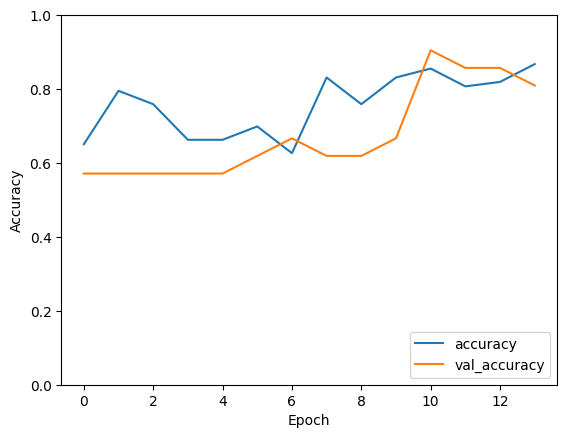

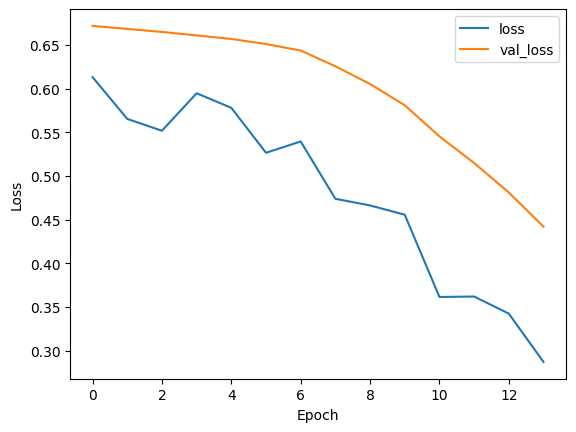

In [37]:
# Visualize the Training Process
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()